# Rutherford Scattering simulation

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
import sys

In [233]:
0.2e-9/(1000*(0.197e-15))

1015.2284263959392

## Constants

In [230]:
# general constants
c = 3.0e8

# atomic properties
m_p = 938.272 # MeV/c^2
m_n = 939.565 # MeV/c^2
m_a = 2*m_p + 2*m_n
A_a = 4
Z_a = 2
Na = 6.02214076e23 #particles/mol
alpha = 1.0/137.035999 #fine structure constant-


rho_Au = 19.3 #g/cm^3
A_Au = 196.997 #g/mol
Dat_Au = np.power(rho_Au*Na/A_Au, -1/3)*0.01/(1000*(0.197e-15)) #gold inter atomic distance
th_Au = 0.16e-6 #gold foild thickness
Nat_Au = int(h_Au*2/Dat_Au) #number of consecutive gold atoms
Z_Au = 79

# geometry
source_x = 0
source_y = 0
source_z = 0

In [231]:
print(Dat_Au)

1303.9198822824615


## Source

In [3]:
class Source():
    def __init__(self, s_x, s_y, s_z, s_r, s_a):
        self.source_x = s_x    # x position
        self.source_y = s_y    # y position
        self.source_z = s_z    # z position
        self.source_r = s_r    # radius
        self.source_a = s_a    # activity

    def GenerateParticle(self, E_k, M, N=1):
        # kinematics
        gamma = 1.0 + E_k/M
        beta  = np.sqrt(1 - 1/(gamma*gamma))
        p     = M * gamma * beta
        
        # source point of emission (polar coordinates)
        r_s = np.sqrt(np.random.uniform(0, 1, size=(N,1))) * self.source_r
        t_s = np.random.uniform(0, 1, size=(N,1)) * 2 * np.pi
        
        # source point of emission (carthesian coordinates)
        x_s = self.source_x + r_s * np.cos(t_s)
        y_s = self.source_y * np.ones((N,1))
        z_s = self.source_z + r_s * np.sin(t_s)
        
        # versor of direction (polar coordinates)
        u_pp = np.random.uniform(0, 1, size=(N,1)) * np.pi                 # momentum: phi   (0< phi <pi)
        u_pt = np.arccos(2 * np.random.uniform(0, 1, size=(N,1)) - 1.0)    # momentum: theta (0<theta<pi)
        
        # versor of direction (carthesian coordinates)
        u_px = np.cos(u_pp)*np.sin(u_pt)    # momentum : x
        u_py = np.sin(u_pp)*np.sin(u_pt)    # momentum : y
        u_pz = np.cos(u_pt)                 # momentum : z
        
        # momentum of alphas (carthesian coordinates)
        px = u_px * p
        py = u_py * p
        pz = u_pz * p
        
        return [
            np.hstack((r_s,t_s)),
            np.hstack((x_s,y_s,z_s)),
            np.hstack((r_s,t_s)),
            np.hstack((u_px,u_py,u_pz)),
            np.hstack((px,py,pz))
        ]

In [4]:
source = Source(0,0,0,1,300)
source.GenerateParticle(4.8, m_a, 1)

[array([[0.91263067, 2.49757974]]),
 array([[-0.72982419,  0.        ,  0.547952  ]]),
 array([[0.91263067, 2.49757974]]),
 array([[0.87733252, 0.46029699, 0.13569943]]),
 array([[166.64124649,  87.42918279,  25.77485914]])]

## Particle

In [325]:
class Particle():
    def __init__(self, source, E_k, M, N=1):
        self.source = source
        particles = source.GenerateParticle(E_k, M, N)
        self.particle_x  = particles[1][:,0]
        self.particle_y  = particles[1][:,1]
        self.particle_z  = particles[1][:,2]
        self.particle_px = particles[4][:,0]
        self.particle_py = particles[4][:,1]
        self.particle_pz = particles[4][:,2]
        self.particle_m  = M
        self.particle_E  = E_k*np.ones((N,))
    
    def FreeEvolutionDx(self, dx):
        self.particle_x += dx
        dt = dx*self.particle_m/self.particle_px
        self.particle_z += dt*self.particle_pz/self.particle_m
        self.particle_y += dt*self.particle_py/self.particle_m
   
    def FreeEvolutionDy(self, dy):
        self.particle_y += dy
        dt = dy*self.particle_m/self.particle_py
        self.particle_x += dt*self.particle_px/self.particle_m
        self.particle_z += dt*self.particle_pz/self.particle_m
   
    def FreeEvolutionDz(self, dz):
        self.particle_z += dz
        dt = dz*self.particle_m/self.particle_pz
        self.particle_x += dt*self.particle_px/self.particle_m
        self.particle_y += dt*self.particle_py/self.particle_m
        
    def FreeEvolutionDt(self, dt):
        self.particle_x += dt*3.0e8*self.particle_px/self.particle_m
        self.particle_y += dt*3.0e8*self.particle_py/self.particle_m
        self.particle_z += dt*3.0e8*self.particle_pz/self.particle_m
        
    def TimeEvolution(self, F, dt):
        #v(i+1)= vi +ai*dt
        #x(i+1)= xi +v(i+1)*dt 
        # x_(i+1) = x_i + t_i*px_i/M
        # px_(i+1) = px_i + F_i*t_i
        pass
    
    def Collimate(self, collimator):
        mask = collimator.Passage(self.particle_x, self.particle_z)
        self.particle_x  = self.particle_x  [mask]
        self.particle_y  = self.particle_y  [mask]
        self.particle_z  = self.particle_z  [mask]
        self.particle_px = self.particle_px [mask]
        self.particle_py = self.particle_py [mask]
        self.particle_pz = self.particle_pz [mask]
        self.particle_E  = self.particle_E  [mask]
        
    def Interact(self, target):
        a, tau = target.Scatter(self.particle_E, Z_a) 
        ct = np.cos(tau) 
        st = np.sin(tau) 
        ca = np.cos(a)
        sa = np.sin(a)
        # y rotation for alpha z rotation tau
        self.particle_px = + ct*ca*self.particle_px - st*self.particle_py + ct*sa*self.particle_pz
        self.particle_py = + st*ca*self.particle_px + ct*self.particle_py + st*sa*self.particle_pz
        self.particle_pz = -    sa*self.particle_px                       +    ca*self.particle_pz 
        # y rotation for alpha x rotation tau       
        #self.particle_px = +    ca*self.particle_px                       +    sa*self.particle_pz
        #self.particle_py = + st*ca*self.particle_px + ct*self.particle_py - st*ca*self.particle_pz
        #self.particle_pz = - ct*sa*self.particle_px + st+self.particle_y  + ct*ca*self.particle_pz        
    
    def GetTrack(self):
        return [
            self.particle_x,
            self.particle_y,
            self.particle_z
        ]
    
    def TrackCylinder(self, r, old_x, old_y, old_z):
        a = np.power(self.particle_x-old_x,2) + np.power(self.particle_y-old_y,2)
        b = old_x * (self.particle_x-old_x) + old_y * (self.particle_y-old_y)
        t = (-b + np.sign(self.particle_y) * np.sqrt(np.power(b,2) + a*r*r)) / a
        
        x_cyl = old_x + t * (self.particle_x-old_x)
        y_cyl = old_y + t * (self.particle_y-old_y)
        z_cyl = old_z + t * (self.particle_z-old_z)
        
        t_cyl = np.arccos(x_cyl/r)
        
        return [x_cyl, y_cyl, z_cyl, t_cyl]

In [326]:
particles = Particle(source, 4.8, m_a)

In [327]:
particles.particle_x

array([-0.00240433])

## Collimator

In [328]:
class Collimator():
    def __init__(self, c_x, c_y, c_z, c_w, c_h):
        self.collimator_x = c_x    # x origin    +++++   ^z
        self.collimator_y = c_y    # y origin    +   +   |
        self.collimator_z = c_z    # z origin    o++++   x--->x
        self.collimator_w = c_w    # width
        self.collimator_h = c_h    # height
        
    def Passage(self, x, z):
        # if x>self.collimator_x and x <self.collimator_x+self.collimator_w and \
        #    y>self.collimator_y and y <self.collimator_y+self.collimator_h:
        #     return True
        # else:
        #     return False
        col_x = np.ones(x.shape) * self.collimator_x
        col_z = np.ones(z.shape) * self.collimator_z
        mask_x = np.logical_and(x>col_x, x<col_x+self.collimator_w)
        mask_z = np.logical_and(z>col_z, z<col_z+self.collimator_h)
        mask   = np.logical_and(mask_x, mask_z)
        return mask

## Target scatter

In [329]:
# https://robolab.unex.es/wp-content/plugins/papercite/pdf/rutherford-simple-scattering.pdf
#classical treatment
#given a particle i generate 2 numbers x,y in (a, Dat/2)
# Dat is the inter atomic distance Dat=(rho*NA/A)^-1/3
#rho density A atomic mass NA avogadros number
# the impact parameter is sqrt(x2+y2)


class Target():
    def __init__(self, t_x, t_y, t_z, t_t, t_r, t_A, t_Z):
        self.target_x = t_x
        self.target_y = t_y
        self.target_z = t_z
        self.target_t = t_t #target thickness
        self.target_r = t_r #target density (rho)
        self.target_A = t_A #target atomic mass
        self.target_Z = t_Z #target effective atomic number
        self.target_D = np.power(t_r*Na/t_A, -1.0/3.0)*0.01/(1000*(0.197e-15))#-15 giusto #target interatomic distance
    
    def Scatter(self, E, q): #energy and charge of projectyle
        x = np.random.uniform(-self.target_D/2,self.target_D/2, E.shape)
        y = np.random.uniform(-self.target_D/2,self.target_D/2, E.shape)
        a = np.arctan(x/y)
        b = np.sqrt(np.square(x)+np.square(y))
        k_2tb = q*self.target_Z*alpha / (2*E*b)
        theta = np.pi - 2*np.arccos(k_2tb / np.sqrt(1 + np.square(k_2tb)))
        #print("k2tb: ",np.mean(k_2tb), " mean theta ",np.mean(theta))
        tau = np.arctan(np.sin(theta)/(np.cos(theta)+ A_a/self.target_A))
        #print(np.mean(tau))
        return a, tau

## Test

### Geometry and evolution

In [330]:
import cupy as np
np.cuda.Device(0).use()

#import numpy as np

In [331]:
N = 1000000#10000000
k = 2000#1000
patience = 1


x_cyl = np.array([])
y_cyl = np.array([])
z_cyl = np.array([])
t_cyl = np.array([])

source = Source(0, -0.05, 0, 0.003, 300)
col1 = Collimator(-0.001, -0.04, -0.002, 0.002, 0.004)
col2 = Collimator(-0.001,  0.00, -0.002, 0.002, 0.004)
target = Target ( 0.0, 0.0, 0.0, th_Au, rho_Au, A_Au, Z_Au)

start = time.time()
for i in range(k):
    if ( i % patience == 0 ):
        sys.stdout.write("\rCompleteness : "+str(round(i/k*100,1))+"%")
    particles = Particle(source, 4.8, m_a, N)

    particles.FreeEvolutionDy(0.01)
    particles.Collimate(col1)
    particles.FreeEvolutionDy(0.04)
    particles.Collimate(col2)
    particles.Interact(target)

    x_old = copy.deepcopy(particles.particle_x)# track1[0]# np.copy(particles.particle_x)
    y_old = copy.deepcopy(particles.particle_y)# track1[1]# np.copy(particles.particle_y)
    z_old = copy.deepcopy(particles.particle_z)# track1[2]# np.copy(particles.particle_z)

    # particles.FreeEvolutionDy(0.05)

    particles.FreeEvolutionDt(1e-8)

    track = particles.TrackCylinder(0.05, x_old, y_old, z_old)

    x_cyl = np.hstack((x_cyl,track[0]))
    y_cyl = np.hstack((y_cyl,track[1]))
    z_cyl = np.hstack((z_cyl,track[2]))
    t_cyl = np.hstack((t_cyl,track[3]))
    del particles
    del x_old
    del y_old
    del z_old

print("\nCompleted")  
print(time.time()-start)

Completeness : 100.0%
Completed
26.878254175186157


In [332]:
t_cyl.shape

(447612,)

### Plot of the track

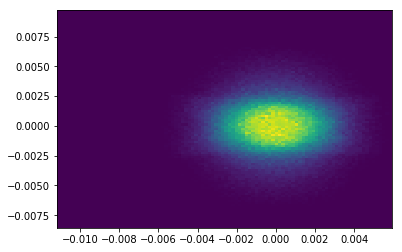

In [333]:
#plt.hist2d(x_cyl, z_cyl, bins=[100,100])
plt.hist2d(np.asnumpy(x_cyl), np.asnumpy(z_cyl), bins=[100,100])
plt.show()

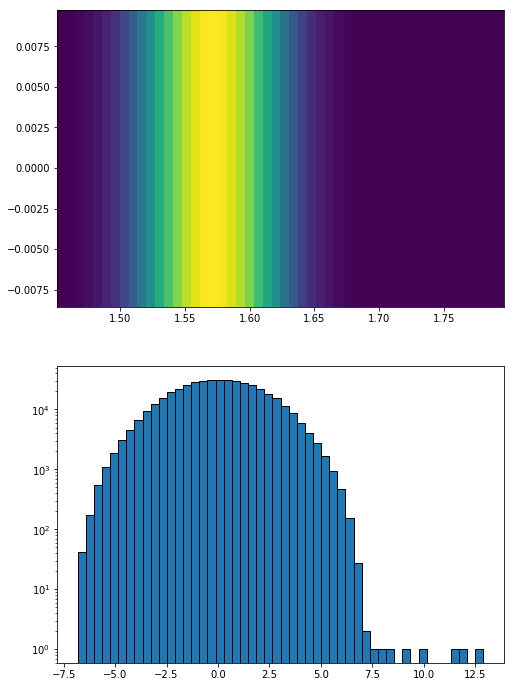

In [334]:
fig=plt.figure(figsize=(8, 12))

plt.subplot(2,1,1)
#plt.hist2d(t_cyl, z_cyl, bins=[50,1])
plt.hist2d(np.asnumpy(t_cyl), np.asnumpy(z_cyl), bins=[50,1])

plt.subplot(2,1,2)
#plt.hist(t_cyl, bins=50, edgecolor='black')
plt.hist(np.asnumpy(t_cyl*360.0/(2*np.pi)-90.0), bins=50, edgecolor='black')
plt.yscale('log')
plt.show()